In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export


import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator
from statsmodels.stats.multitest import multipletests

from scipy.stats import fisher_exact



pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
save = True     # whether or not to save elment to disk
user = 'general'     # defines top hierarchy of output folder
outfolder = '07_cluster_descriptions'    # name of notebook

data_to_load = 'general/05_join_clusters_umap/05_data_umap_clusters_220901_1642.csv.gz'

def dump_table(df, name):
    if save:
        export.full_frame(
            user, 
            f'{outfolder}/{name}', 
            df, 
            index=True,
            date=False
        )

def dump_figure(name):
    if save: 
        export.image(
            user,
            f'{outfolder}/{name}',
        )

In [4]:
data = pd.read_csv(
    inout.get_material_path(data_to_load), 
    index_col=0)

In [5]:
print(f"Total number of patients: {data.Patient_id.nunique()}")
print(f"Total number of ICU-days: {data.shape[0]}")

Total number of patients: 585
Total number of ICU-days: 12495


In [6]:

data.Discharge_disposition = data.Discharge_disposition.astype("category")

data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home',
    'Rehab', 
    'SNF',
    'LTACH',
    'Hospice',
    'Died'
])

DISCHARGE_STACKS = [
    ('Home', 'Rehab', 'SNF', 'LTACH'),
    ('Hospice', 'Died')
]
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

In [7]:
#rename to match old code 

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

# BALs per cluster

In [8]:
df = data.loc[data.has_bal, :].groupby(["cluster"]).count().day.reset_index()


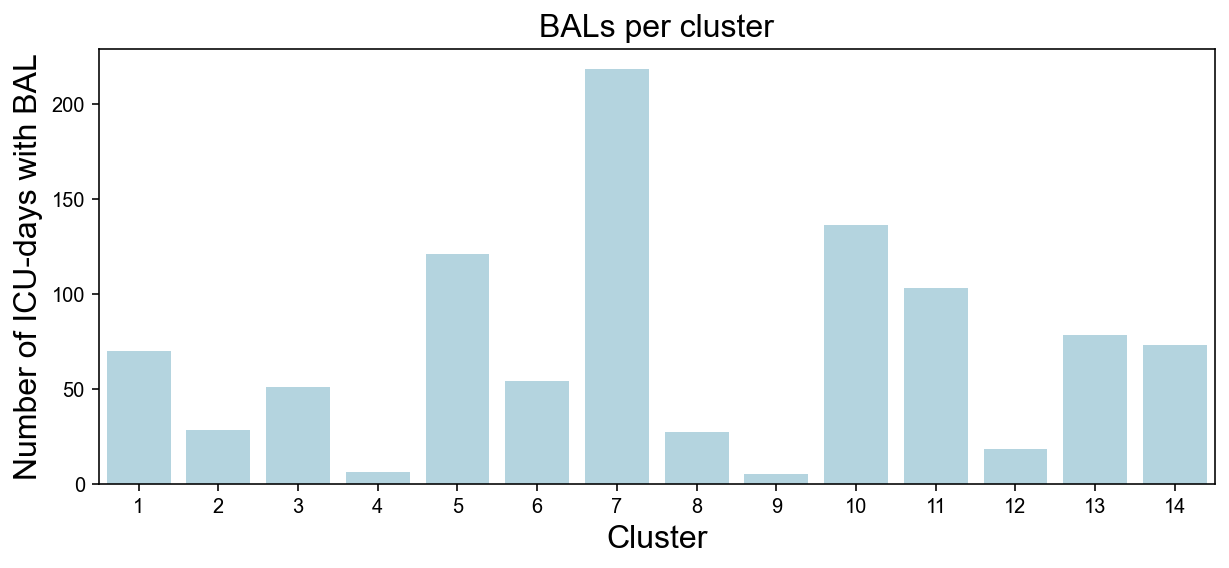

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    data=df, 
    x="cluster", 
    y="day", 
    color='lightblue'
)


ax.set_ylabel("Number of ICU-days with BAL", size=16)
ax.set_xlabel("Cluster", size=16)
ax.set_title("BALs per cluster", size=16)

dump_figure('BALs_per_cluster.pdf')

# First cluster per patient

In [10]:
first_days = data.groupby("patient").head(1).index

In [11]:
df = data.loc[first_days, :].groupby(["Discharge_disposition"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_1": "cluster"}, axis=1)


In [12]:
def plot(df):

    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    clustering.stacked_hue_barplot(
        df=df, 
        x="cluster", 
        y="count", 
        hue="Discharge_disposition", 
        stacks=DISCHARGE_STACKS,
        ax=ax,
        palette=mpl.colors.ListedColormap(DISCH_PALETTE),
    )
    ax.set_xlabel("Cluster", size=16)
    ax.set_ylabel("Number of patients", size=16)
    # ax.set_title("Distribution of first clusters for patients", size=16);
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_xlim(-1, 14 * 9 - 1)
    
    
    

def get_p_values(df):


    toy = df.copy()
    toy.loc[:, 'passed'] = toy['Discharge_disposition'].isin(['Hospice', 'Died'])
    total = toy.groupby('passed')['count'].sum()

    clusters = sorted(toy['cluster'].unique())
    res = pd.Series(index=clusters, data=False)
    for c in toy['cluster'].unique():
        d = toy[toy['cluster']==c]
        d = d.groupby(['passed'])['count'].sum()
        d = d.reindex([True, False]).fillna(0)

        a = d[True]
        b = d[False]
        a2 = total[True] - a
        b2 = total[False] - b
        _, pval = fisher_exact(
            ((a, b), (a2, b2))
        )
        res[c] = pval
    res = res.to_frame('fishers').rename_axis('cluster')
    res['benjamini_hochberg'] = multipletests(res['fishers'], method='fdr_bh')[1]

    return res    


,fishers,benjamini_hochberg
cluster,,
1,0.000677,0.004736
2,1.0,1.0
3,0.000191,0.002672
4,0.326473,0.415511
5,0.005988,0.027946
6,1.0,1.0
7,0.4329,0.50505
8,0.140219,0.280437
9,0.091614,0.213766


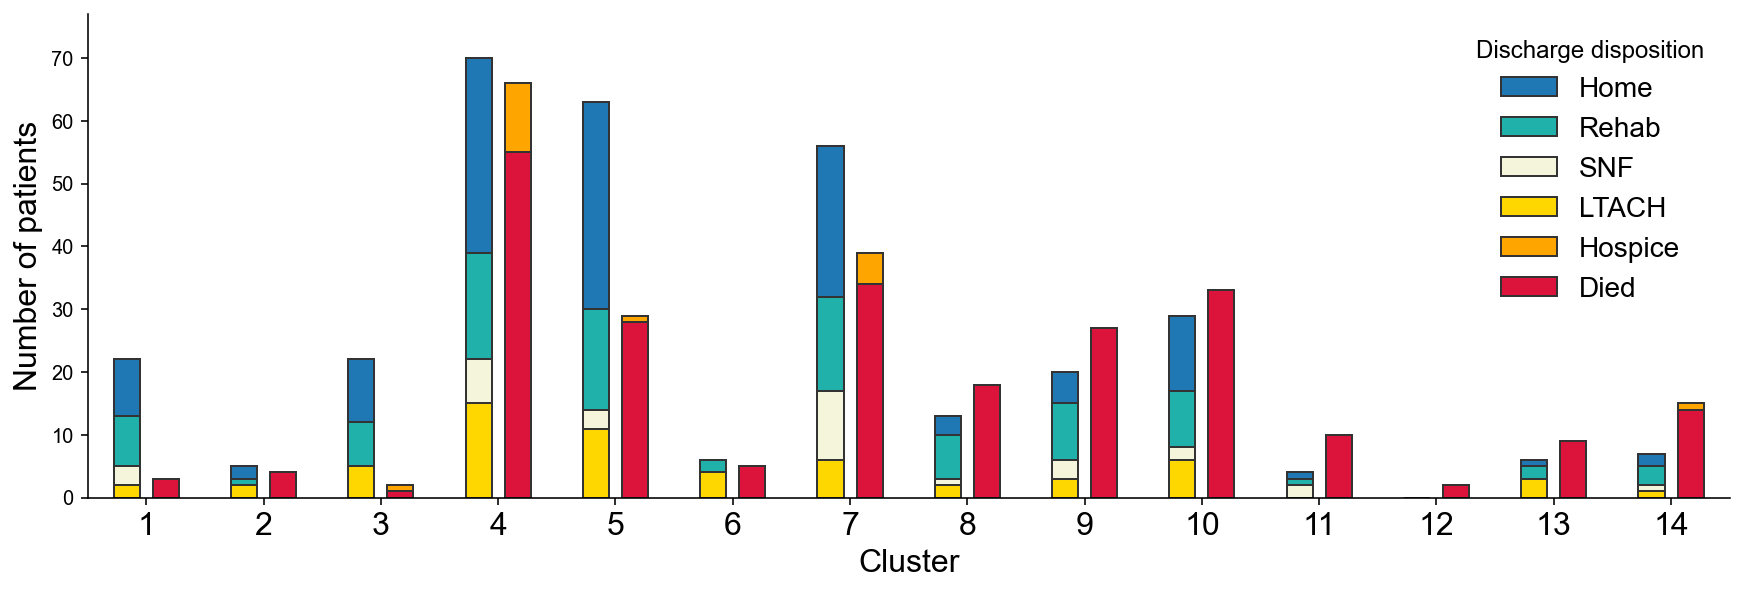

In [13]:
plot(df)  
dump_figure('first_cluster.pdf')

pvals = get_p_values(df)
dump_table(pvals, 'first.xlsx')
display(pvals)

# Last cluster for patient

In [14]:
last_days = data.groupby("patient").tail(1).index

In [15]:
df = data.loc[last_days, :].groupby(["Discharge_disposition"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_1": "cluster"}, axis=1)


,fishers,benjamini_hochberg
cluster,,
1,1.0,1.0
2,0.02215,0.03101
3,0.000017,0.000039
4,0.0,0.0
5,0.039724,0.050558
6,0.004022,0.007039
7,0.002873,0.005745
8,0.316344,0.355435
9,0.018147,0.028228


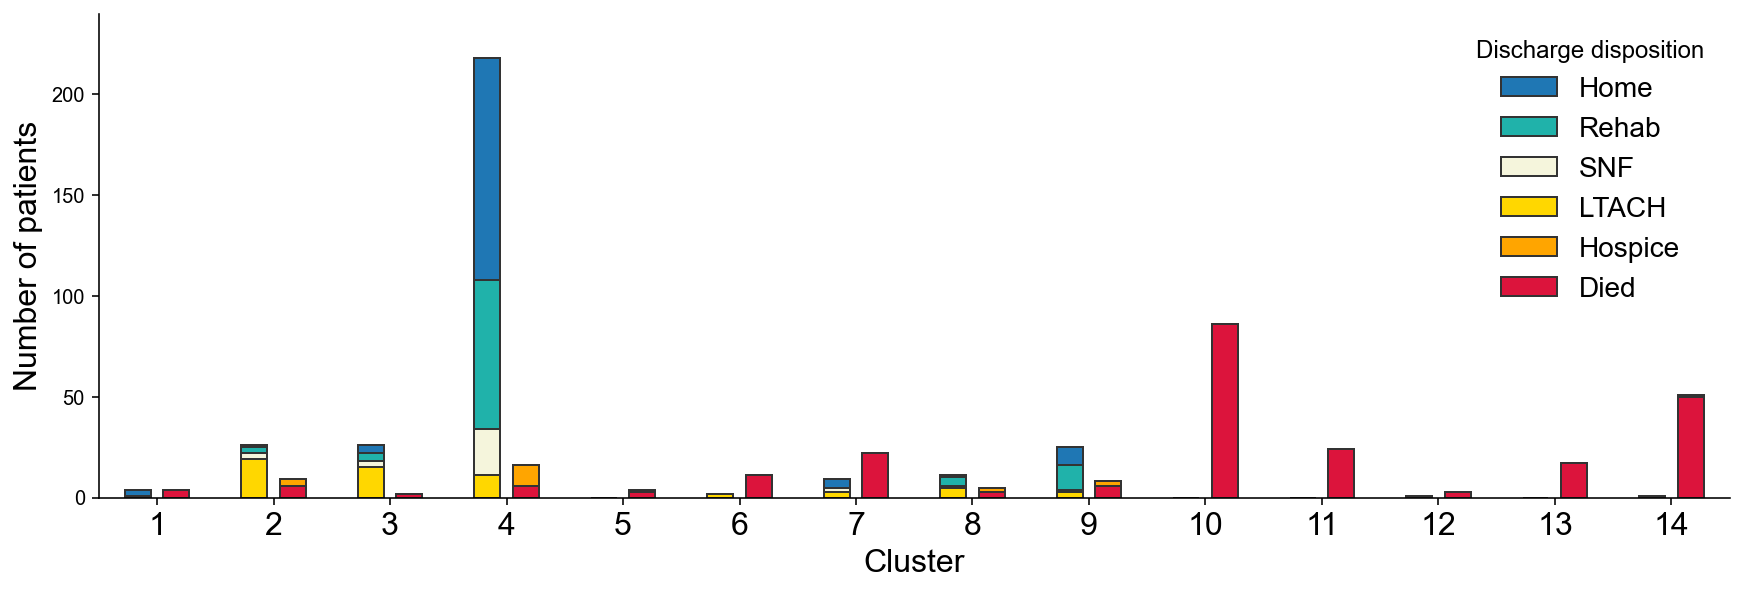

In [16]:
plot(df)  
dump_figure('last_cluster.pdf')

pvals = get_p_values(df)
dump_table(pvals, 'last_cluster.xlsx')
display(pvals)

In [17]:
for j in pvals.index:
    print(j, pvals.loc[j, 'benjamini_hochberg'])

1 1.0
2 0.031010144865821397
3 3.9406011359632393e-05
4 9.841710483491444e-57
5 0.05055801432620222
6 0.0070390978303983415
7 0.005745152244699433
8 0.355435302946673
9 0.028228248470437953
10 7.040560825569653e-34
11 8.080318492139906e-09
12 0.355435302946673
13 2.444752048271722e-06
14 1.2344051440753998e-17
